In [1]:
from defillama2 import DefiLlama
import yfinance as yf
from datetime import date
import pandas as pd
from matplotlib.ticker import PercentFormatter
from number_formatter import usd_or_num_formatter

In [2]:
# < user input > #
base_date_tvl_chart = date(2023, 1, 1)
base_date_stb_chart = date(2022, 1, 20)

In [3]:
obj = DefiLlama()

In [4]:
# get historical DeFi TVL of all chains from DefiLlama
df_tvl = obj.get_defi_hist_tvl()
df_tvl.index = df_tvl.index.date # for joining with price frame 
df_tvl = df_tvl.rename(columns={'tvl': 'TVL'})
df_tvl.tail()

,TVL
2023-05-16,7.453343e+10
2023-05-17,7.469786e+10
2023-05-18,7.410700e+10
2023-05-19,7.373824e+10
2023-05-20,7.391368e+10


In [5]:
# download daily prices from Yahoo
start = df_tvl.index[0]
end = df_tvl.index[-1]
tickers_names = {
    'BTC-USD':'BTC', 
    'ETH-USD':'ETH'
}
tickers = list(tickers_names.keys())
# downloads prices since `start` (including `start`) 
df_prices = yf.download(tickers, start, end)['Adj Close'] \
    .rename(tickers_names, axis=1)
df_prices.columns.name = None
df_prices.tail()

[*********************100%***********************]  2 of 2 completed


,BTC,ETH
Date,,
2023-05-14,26930.638672,1800.500977
2023-05-15,27192.693359,1817.549927
2023-05-16,27036.650391,1824.121460
2023-05-17,27398.802734,1821.859619
2023-05-18,26832.208984,1801.728516


In [6]:
# join TVL and Prices 
df = df_prices.join(df_tvl, how='inner').fillna(method='ffill')
df.head()

,BTC,ETH,TVL
2018-08-16,6334.729980,288.045990,5576.441690
2018-08-17,6580.629883,315.729004,8660.109290
2018-08-18,6423.759766,295.812012,8029.681229
2018-08-19,6506.069824,300.834015,7689.980712
2018-08-20,6308.529785,274.315002,7818.098047


In [7]:
# calc cumulative pct change from the base date
df_chng = df.loc[base_date_tvl_chart:]\
    .apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))
df_chng.head()

,BTC,ETH,TVL
2023-01-01,0.000000,0.000000,0.000000
2023-01-02,0.381295,1.140064,0.427008
2023-01-03,0.329486,1.150239,1.225842
2023-01-04,1.432524,4.626427,1.346554
2023-01-05,1.273114,4.119501,3.256232


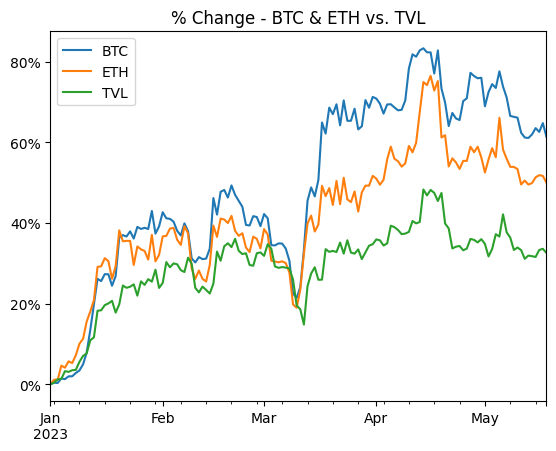

In [8]:
# plot
ax = df_chng.plot(title = '% Change - BTC & ETH vs. TVL')
ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))

In [9]:
# get stablecoin ids
df = obj.get_stablecoins_circulating()
ss = df.loc[:, 'name']
ss

id
1               Tether
2             USD Coin
3      TerraClassicUSD
4          Binance USD
5                  Dai
            ...       
106     Electronic USD
107        Czodiac USD
108          Deuterium
109               eUSD
110             crvUSD
Name: name, Length: 109, dtype: object

In [10]:
lst = []
stables = ['Tether', 'USD Coin', 'Binance USD']
for stablecoin in stables:
    stablecoin_id = ss.index[ss == stablecoin].values[0]
    da = obj.get_stablecoin_hist_mcap(stablecoin_id)[['totalCirculatingUSD']]\
        .rename(columns={"totalCirculatingUSD": stablecoin})
    da[stablecoin] = da[stablecoin] / 1e9
    lst.append(da)
df_mcap = pd.concat(lst, axis=1)
df_mcap['All 3'] = df_mcap['Tether'] + df_mcap['USD Coin'] + df_mcap['Binance USD']
df_mcap.index = df_mcap.index.date 
df_mcap.head()

,Tether,USD Coin,Binance USD,All 3
2020-12-31,20.953469,3.707668,0.897388,25.558525
2021-01-01,20.935117,3.931692,0.986932,25.853741
2021-01-02,21.165736,4.121592,1.075328,26.362656
2021-01-03,21.269142,4.138859,1.145870,26.553871
2021-01-04,21.365922,4.213378,1.171210,26.750509


In [11]:
df_mcap.tail()

,Tether,USD Coin,Binance USD,All 3
2023-05-16,82.892087,29.737667,5.582511,118.212264
2023-05-17,82.914915,29.544930,5.572004,118.031849
2023-05-18,82.840018,29.371839,5.562351,117.774207
2023-05-19,82.843574,29.510053,5.562106,117.915733
2023-05-20,82.895728,29.420007,5.517302,117.833037


In [12]:
# calc cumulative $ change from the base date
df_stable_mcap_chng = df_mcap.loc[base_date_stb_chart:]\
    .apply(lambda x: x.subtract(x.iloc[0]))
df_stable_mcap_chng.head()

,Tether,USD Coin,Binance USD,All 3
2022-01-20,0.000000,0.000000,0.000000,0.000000
2022-01-21,-0.010744,0.435253,-0.028784,0.395724
2022-01-22,-0.211904,0.560390,-0.076608,0.271879
2022-01-23,0.346207,2.153853,0.062167,2.562228
2022-01-24,0.009405,2.202553,-0.202457,2.009502


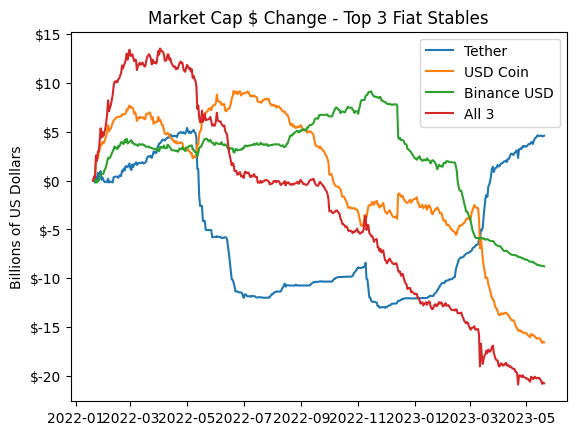

In [13]:
ax = df_stable_mcap_chng.plot(title = 'Market Cap $ Change - Top 3 Fiat Stables')
ax.yaxis.set_major_formatter(usd_or_num_formatter(True, decimals=0))
ax.set_ylabel('Billions of US Dollars');